In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lyricwikia
import lyricsgenius as lg

In [5]:
# load data
train_data = pd.read_csv('MoodyLyricsPN.csv')
test_data = pd.read_csv('labeled_lyrics_cleaned.csv')

In [6]:
print('Train data size:', train_data.shape, '\nTrain data labels: ', list(train_data.columns.values))
print('Distribution of mood/sentiment in train set\n', train_data['mood'].value_counts())
print('Test data size:', test_data.shape, '\nTest data labels: ', list(test_data.columns.values))

Train data size: (5000, 4) 
Train data labels:  ['index', 'artist', 'title', 'mood']
Distribution of mood/sentiment in train set
 pos    2500
neg    2500
Name: mood, dtype: int64
Test data size: (158353, 5) 
Test data labels:  ['Unnamed: 0', 'artist', 'seq', 'song', 'label']


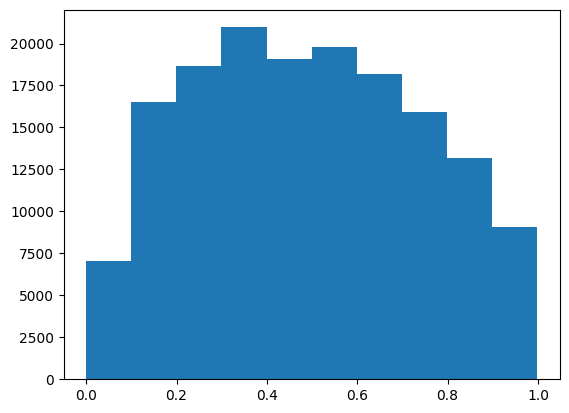

In [7]:
# Distribution of spotify valence value in the test set
plt.hist(test_data['label'], bins=10)
plt.show()